# 11. Spacery losowe po grafach: algorytm wyszukiwania klastrów

Dla dużych grafów istotną informacją jest wykrycie podgrafów, które są silnie ze sobą powiązane. Za pomocą spacerów losowych po grafach zaprojektuj algorytm, który odkrywa strukturę klastrów w grafie (clustering algorithm). Wykorzystaj swój algorytm do wskazania krytycznych wierzchołków, tj. wierzchołków, których usunięcie rozspójnia graf. Przeanalizuj wariant algorytmu dla grafów skierowanych i grafów nieskierowanych.

In [404]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Graf skierowany z wagami

{(0, 1): 0.5,
 (0, 2): 0.5,
 (1, 0): 0.33,
 (1, 3): 0.33,
 (1, 4): 0.33,
 (2, 0): 0.33,
 (2, 5): 0.33,
 (2, 6): 0.33,
 (3, 1): 1.0,
 (4, 1): 1.0,
 (5, 2): 1.0,
 (6, 2): 1.0}

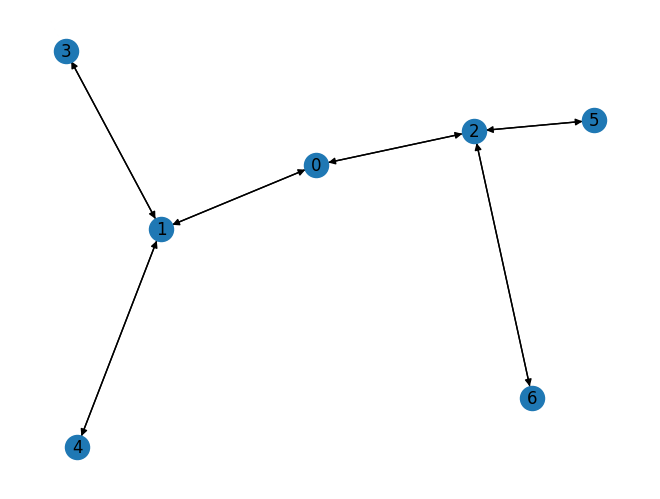

In [405]:
G = nx.balanced_tree(2, 2)
pos = nx.spring_layout(G)

A = nx.adjacency_matrix(G)
x, y = A.shape

new_G = nx.DiGraph()
for current_node in range(x):
    for adjacent_node in range(y):
        if A[current_node, adjacent_node] == 1:
            p = round(1 / G.degree(current_node), 2)
            new_G.add_edge(current_node, adjacent_node, weight=p)

pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True)
nx.get_edge_attributes(new_G, 'weight')

# DiGraph example
# nx.draw(new_G, pos, with_labels=True, arrows=True, connectionstyle='arc3, rad = 0.1')
# labels = nx.get_edge_attributes(new_G, 'weight')
# nx.draw_networkx_edge_labels(new_G, pos, edge_labels=labels)

# Eksperymenty z stationary distribution

In [406]:

def stationary_distrib_1(P):
    eigenvals, eigenvects = np.linalg.eig(P.T)
    close_to_1_idx = np.isclose(eigenvals, 1)
    target_eigenvect = eigenvects[:,close_to_1_idx]
    target_eigenvect = target_eigenvect[:,0]

    return target_eigenvect / sum(target_eigenvect)

def stationary_distrib_2(G, P, k=100, starting_node=0):
    nodes_num = len(G.nodes())
    pi = np.zeros((nodes_num, 1))
    pi[starting_node] = 1
    # pi = np.full((1, nodes_num), 1 / nodes_num).flatten()
    # print(pi)
    for _ in range(k):
        new_pi = np.dot(P.T, pi)
        if np.allclose(pi, new_pi):
            return pi
        pi = new_pi
    return pi.reshape(1, -1).flatten()

def pagerank_test(G):
    print("PageRank")
    p_dict = nx.pagerank(G)
    p_sort = sorted(p_dict.items(), key=lambda x: x[1], reverse=True) 
    print(p_dict)
    for i in p_sort: 
        print(i[0], end=", ")
    print("\n")

# Funkcje - transition matrix i adjacency matrix

In [407]:
def adj_matrix(G):
    A = nx.adjacency_matrix(G)
    A = A.todense()
    return np.array(A, dtype = np.float64)

def transition_matrix_1(A):
    D = np.diag(np.sum(A, axis=0))
    return np.dot(np.linalg.inv(D), A)
    
def transition_matrix_2(A):
    return A / A.sum(axis=1, keepdims=True)

# Testy funkcji

In [408]:
A = adj_matrix(G)
P1 = transition_matrix_1(A)
P2 = transition_matrix_2(A)

assert np.array_equal(P1, P2)
P = P1

# print("Distrib1")
# S1 = stationary_distrib_1(P)
# S1_dict = {i: S1[i] for i in range(len(S1))}
# p_sort = sorted(S1_dict.items(), key=lambda x: x[1], reverse=True) 
# print(S1_dict)
# for i in p_sort: 
#     print(i[0], end=", ")
# print("\n")

print("Distrib2 - random walk")
S2 = stationary_distrib_2(G, P, k=104, starting_node=0)
S2_dict = {i: S2[i] for i in range(len(S2))}
p_sort = sorted(S2_dict.items(), key=lambda x: x[1], reverse=True) 
print(S2_dict)
for i in p_sort: 
    print(i[0], end=", ")
print("\n")


pagerank_test(G)


Distrib2 - random walk
{0: 0.3333333333333333, 1: 0.0, 2: 0.0, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666}
0, 3, 4, 5, 6, 1, 2, 

PageRank
{0: 0.1581719960780273, 1: 0.2413134344543876, 2: 0.2413134344543876, 3: 0.08980028375329936, 4: 0.08980028375329936, 5: 0.08980028375329936, 6: 0.08980028375329936}
1, 2, 0, 3, 4, 5, 6, 



# Cluster detection

In [442]:
def pk_visit(P, k):
    pk = np.array([])
    for i in range(1, k + 1):
        pk = np.append(pk, P**i)
    pk = pk.reshape(k, P.shape[0], P.shape[1])
    return pk

def pk_sum(pk, k, node):
    p = pk[0]
    for i in range(1, k):
        p += pk[i]
    return p[node]

def l1_norm(v1, v2):
    return np.sum(np.abs(v1 - v2))

def sim_k(k, v1, v2):
    return np.exp(2 * k - l1_norm(v1, v2)) - 1

def sim_mat(G, P, k, threshold = 1):
    sim_m = np.array([])
    pk = pk_visit(P.copy(), k)
    for frm, to in G.edges():
        s = sim_k(k, pk_sum(pk.copy(), k, frm), pk_sum(pk.copy(), k, to))
        if s <= threshold:
            G[frm][to]['color'] = 'blue'
            G[frm][to]['weights'] = 0.5
        else:
            G[frm][to]['color'] = 'green'
            G[frm][to]['weights'] = 2
        sim_m = np.append(sim_m, s)
    return sim_m

def mark_clusters(G, k = 1, threshold = 1):
    A = adj_matrix(G)
    P = transition_matrix_2(A)
    
    sim_mat(G, P, k, threshold=threshold)

def draw(G, pos):
    edge_colors = [G[u][v]['color'] for u,v in G.edges()]
    weights = [G[u][v]["weights"] for u,v in G.edges()]
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_color="green", width=weights)

# Tests

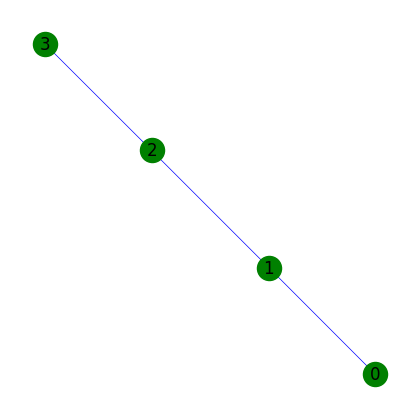

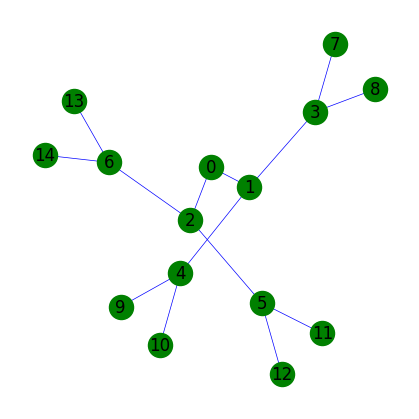

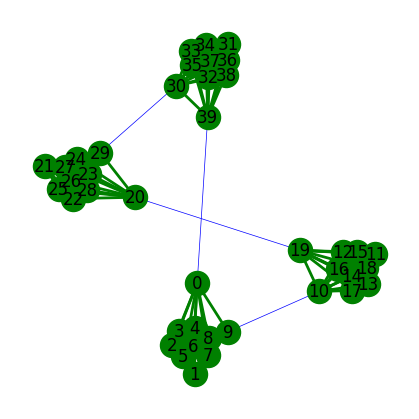

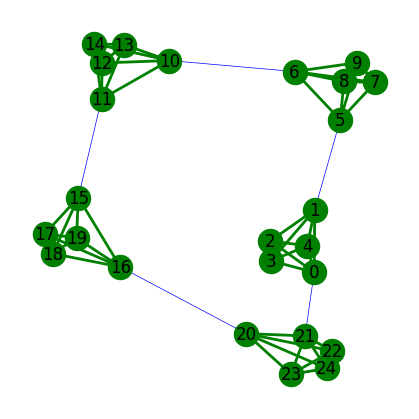

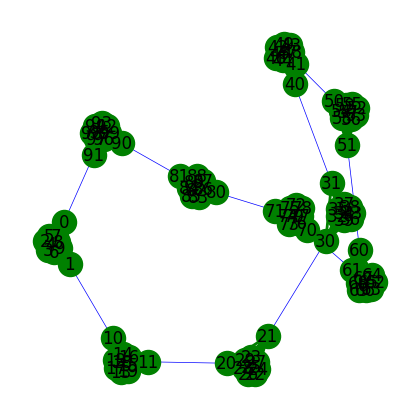

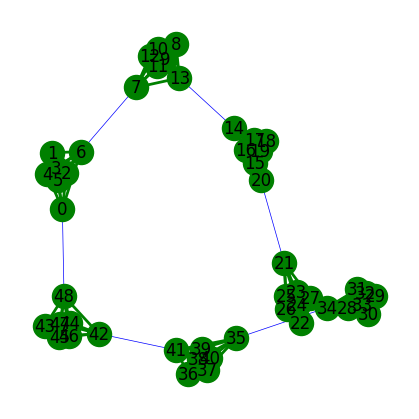

In [458]:
Gs = [nx.balanced_tree(1, 3), nx.balanced_tree(2, 3), nx.connected_caveman_graph(4, 10), nx.ring_of_cliques(5, 5), nx.ring_of_cliques(10, 10), nx.connected_caveman_graph(7, 7)]

for i, G in enumerate(Gs):
    plt.figure(figsize=(4,4))
    plt.figure(i+1)

    pos = nx.spring_layout(G)
    mark_clusters(G, k=1, threshold=1)
    draw(G, pos)

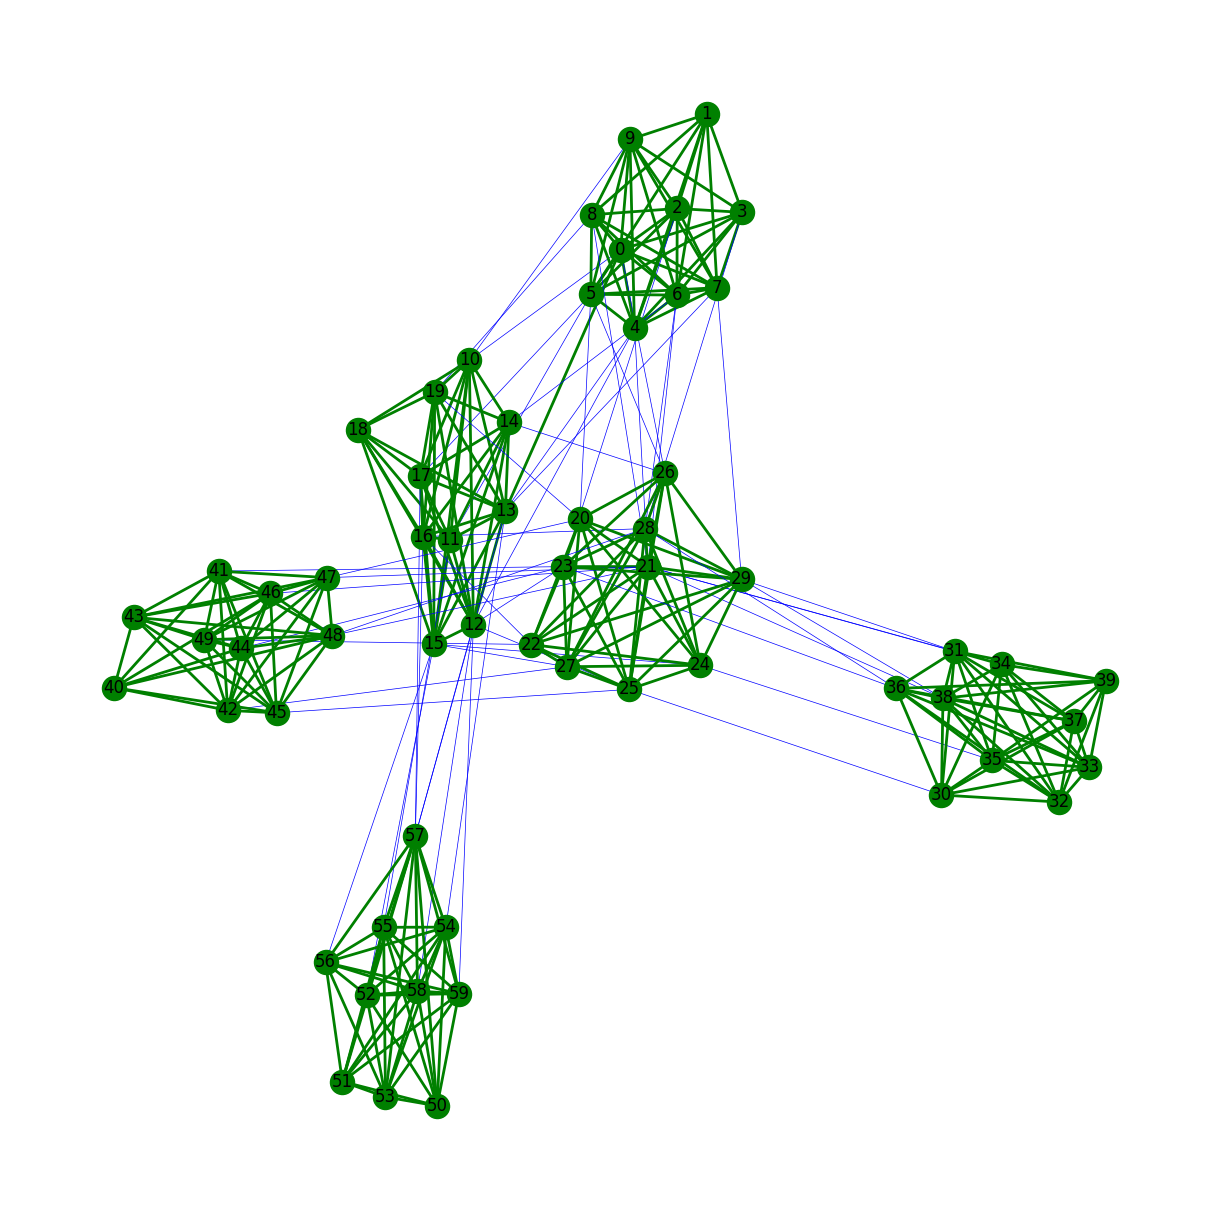

In [471]:
import random

# Generate synthetic graph with clusters
def generate_clustered_graph():
    G = nx.Graph()
    
    # Define clusters
    clusters = {
        0: range(0, 10),
        1: range(10, 20),
        2: range(20, 30),
        3: range(30, 40),
        4: range(40, 50),
        5: range(50, 60),
    }
    
    # Add edges within clusters
    for cluster_id, nodes in clusters.items():
        for i in nodes:
            for j in nodes:
                if i != j and random.random() < 0.8:  # Higher probability of edge within cluster
                    G.add_edge(i, j)
    
    # Add some edges between clusters
    for i in range(10):
        G.add_edge(random.choice(list(clusters[0])), random.choice(list(clusters[1])))
        G.add_edge(random.choice(list(clusters[1])), random.choice(list(clusters[2])))
        G.add_edge(random.choice(list(clusters[0])), random.choice(list(clusters[2])))
        G.add_edge(random.choice(list(clusters[3])), random.choice(list(clusters[2])))
        G.add_edge(random.choice(list(clusters[4])), random.choice(list(clusters[2])))
        G.add_edge(random.choice(list(clusters[5])), random.choice(list(clusters[1])))
    
    return G

# Create the clustered graph
G = generate_clustered_graph()
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 12))
mark_clusters(G, k=1, threshold=1)
draw(G, pos)